#                                Lending Corp Default loan prediction

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,cross_val_predict
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from sklearn.ensemble import GradientBoostingClassifier
import scikitplot as skplt
os.chdir("C:\Imarticus\Projects\Python Project - Bank Lending-20190227T152546Z-001\Python Project - Bank Lending")
print(os.getcwd())

Using TensorFlow backend.


C:\Imarticus\Projects\Python Project - Bank Lending-20190227T152546Z-001\Python Project - Bank Lending


In [2]:
lend_data=pd.read_csv("XYZCorp_LendingData.txt",sep="\t",low_memory=False)

# Dropping variables having more than 30% of missing values

In [3]:
#missing values in the dataset
lend_data.isna().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
total_rev_hi_lim     67313
inq_fi              842681
total_cu_tl         842681
inq_last_12m        842681
default_ind              0
Length: 73, dtype: int64

In [4]:
threshold=len(lend_data)*(0.7)
lend_data=lend_data.dropna(thresh=threshold,axis=1)

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan.

In [5]:
lend_data=lend_data.drop(['id','title','member_id','funded_amnt','funded_amnt_inv',
                'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp',
        'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
        'zip_code','installment','next_pymnt_d','recoveries','collection_recovery_fee','last_credit_pull_d','initial_list_status'],axis=1)

In [6]:
lend_data['emp_title'].nunique()

290912

Since there are 290912 different emp_title values , it needs additional information to make some sense out of it. Hence dropping the variable

In [7]:
lend_data=lend_data.drop(['emp_title'],axis=1)

In [8]:
#sub-grade is redundant information as grade is already present in the dataset
lend_data=lend_data.drop(['sub_grade'],axis=1)

# Imputing missing values

In [9]:
missingNumCols=['tot_coll_amt','tot_cur_bal','total_rev_hi_lim','revol_util']

for col in missingNumCols:
    lend_data[col] = lend_data[col].fillna(lend_data[col].median())


In [10]:
missingCatCols=['emp_length','collections_12_mths_ex_med']
for col in missingCatCols:
    lend_data[col] = lend_data[col].fillna(lend_data[col].mode()[0])


# Visualization (Univariate and Bivariate Analysis)
# Continuous data

In [11]:
def numeric_plot(col_name, full_name):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    sns.distplot(lend_data.loc[lend_data[col_name].notnull(), col_name], kde=False, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    
    sns.boxplot(x='default_ind', y=col_name, data=lend_data, ax=ax2)
    ax2.set_xlabel('Loan Status')
    ax2.set_ylabel(full_name)
    ax2.set_title(full_name + ' by Loan Status')

# Loan Amount

C:\Users\rashm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


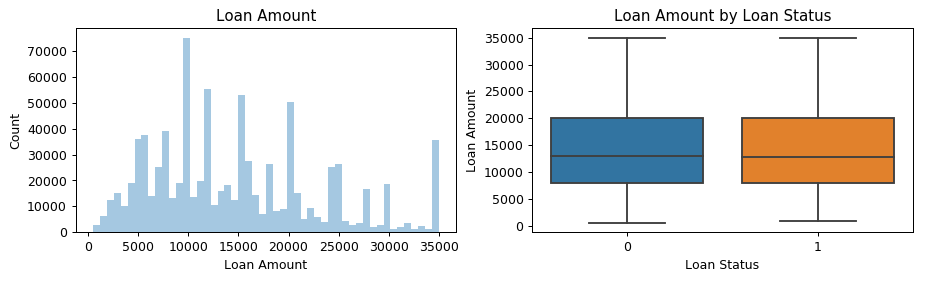

In [12]:
numeric_plot('loan_amnt','Loan Amount')

In [13]:
lend_data.groupby('default_ind')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,14755.476206,8427.151810,500.0,8000.0,13000.0,20000.0,35000.0
1,46467.0,14573.018486,8391.928489,900.0,8000.0,12700.0,20000.0,35000.0


Inference: Loan amount has multimodal distribution. 

# Annual Income

In [14]:
lend_data['log_annual_inc'] = lend_data['annual_inc'].apply(lambda x: np.log10(x+1))

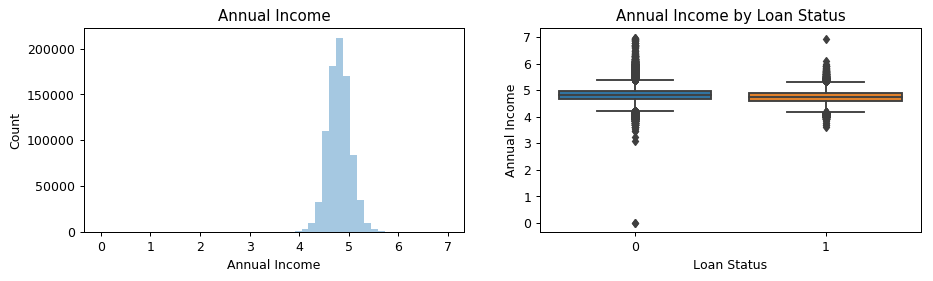

In [15]:
numeric_plot('log_annual_inc','Annual Income')

In [16]:
lend_data.groupby('default_ind')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,4.813480,0.229318,0.000000,4.662767,4.812920,4.954247,6.977724
1,46467.0,4.754257,0.220347,3.610767,4.602071,4.748196,4.892100,6.939848


In [17]:
lend_data.drop('log_annual_inc', axis=1, inplace=True)

Inference: Annual income has skewed distribution. 

# Interest Rate

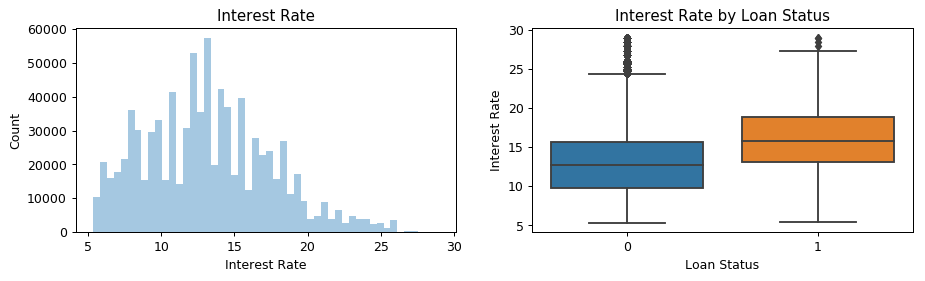

In [18]:
numeric_plot('int_rate','Interest Rate')

In [19]:
lend_data.groupby('default_ind')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,13.030057,4.316366,5.32,9.76,12.69,15.61,28.99
1,46467.0,16.019092,4.301283,5.42,13.05,15.80,18.92,28.99


Inference: Interest rates range from 5.32% to 28.99% with a median of 13.05%. Defaulted loans tend to have higher interest rates

# Debt to Income Ratio

In [20]:
lend_data['dti'].describe()

count    855969.000000
mean         18.122165
std          17.423629
min           0.000000
25%          11.880000
50%          17.610000
75%          23.900000
max        9999.000000
Name: dti, dtype: float64

There are several outliers (75% is 23.9 and max is 9999). So plotting the histogram for dti <60

Text(0.5, 1.0, 'Debt-to-income Ratio')

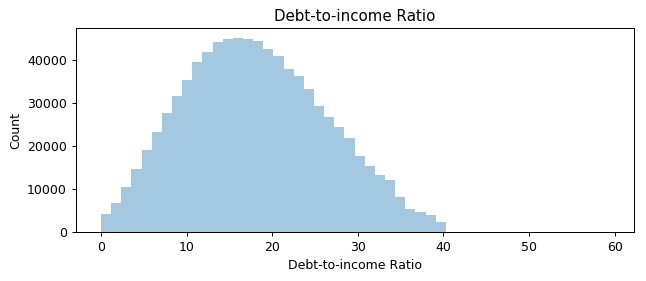

In [21]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(lend_data.loc[lend_data['dti'].notnull() & (lend_data['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

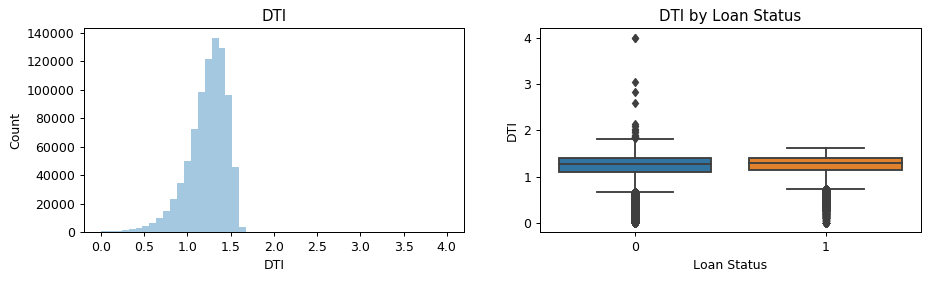

In [22]:
lend_data['log_dti'] = lend_data['dti'].apply(lambda x: np.log10(x+1))
numeric_plot('log_dti','DTI')

In [23]:
lend_data.groupby('default_ind')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,18.103677,17.815005,0.0,11.84,17.57,23.88,9999.00
1,46467.0,18.444234,7.950591,0.0,12.61,18.38,24.14,39.98


In [24]:
lend_data.drop('log_dti', axis=1, inplace=True)

Inference: DTI has skewed distribution.

# Revolving Balance

In [25]:
lend_data['log_revol_bal'] = lend_data['revol_bal'].apply(lambda x: np.log10(x+1))

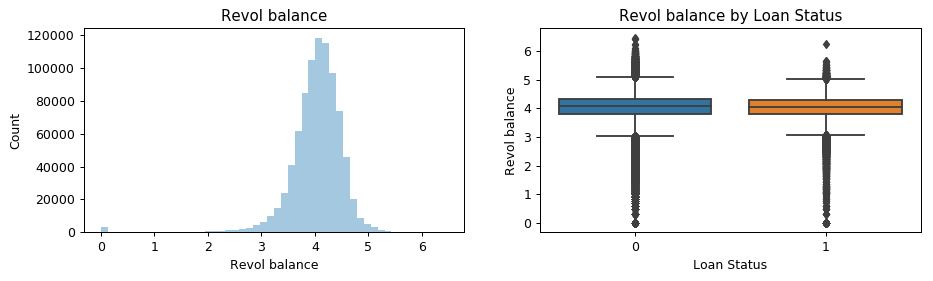

In [26]:
numeric_plot('log_revol_bal','Revol balance')

In [27]:
lend_data.groupby('default_ind')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,4.032126,0.493767,0.0,3.811709,4.077004,4.321510,6.463122
1,46467.0,3.986204,0.531501,0.0,3.794314,4.054996,4.283618,6.242223


In [28]:
lend_data.drop('log_revol_bal', axis=1, inplace=True)

Inference: Revolving Balance doesnt seem have to any significance on loan status

# Revolving Line Utilization 

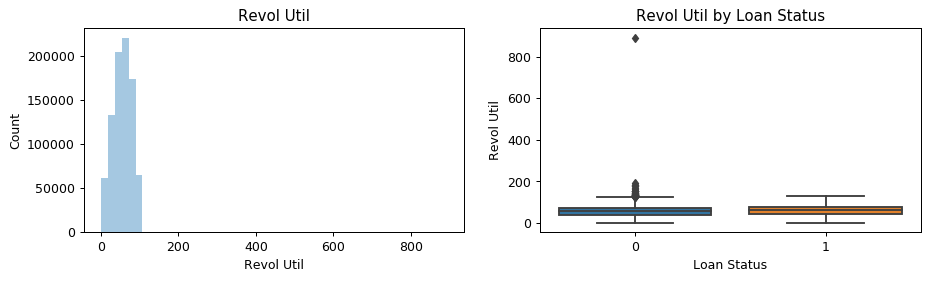

In [29]:
numeric_plot('revol_util','Revol Util')

In [30]:
lend_data.groupby('default_ind')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,54.766177,23.799776,0.0,37.4,55.6,73.2,892.3
1,46467.0,59.439342,23.467230,0.0,43.2,61.5,78.0,129.4


Inference: There is no particular trend to infer anything about this variable

# Total Collection Amount

In [31]:
lend_data['tot_coll_amt'].describe()

count    8.559690e+05
mean     2.076865e+02
std      1.006874e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

Inference: Since 75% of the total collection amount is 0, it will behave like a constant hence drop variable.

In [32]:
lend_data=lend_data.drop(['tot_coll_amt'],axis=1)

# Total Current Balance

In [33]:
lend_data['log_cur_bal'] = lend_data['tot_cur_bal'].apply(lambda x: np.log10(x+1))

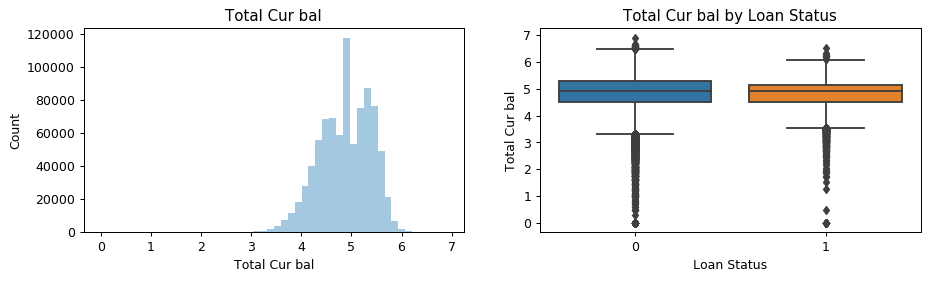

In [34]:
numeric_plot('log_cur_bal','Total Cur bal')

In [35]:
lend_data.groupby('default_ind')['log_cur_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,4.877756,0.524578,0.0,4.508691,4.908536,5.299915,6.903094
1,46467.0,4.814126,0.474351,0.0,4.506201,4.908536,5.139309,6.536215


In [36]:
lend_data.drop('log_cur_bal', axis=1, inplace=True)

Inference: Total current balance has skewed distribution.

# Total Revolving High Limit

In [37]:
lend_data['log_rev_lim'] = lend_data['total_rev_hi_lim'].apply(lambda x: np.log10(x+1))

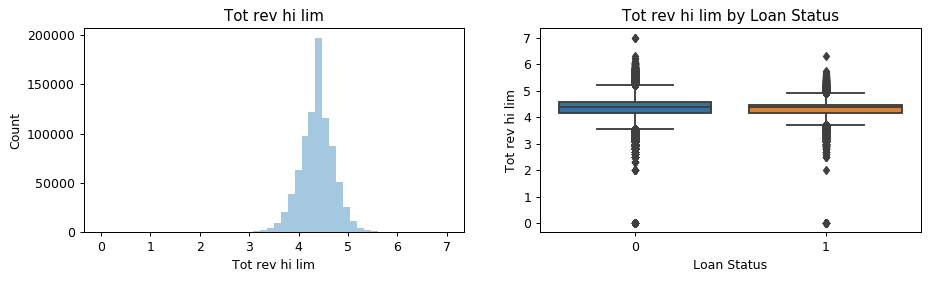

In [38]:
numeric_plot('log_rev_lim','Tot rev hi lim')

In [39]:
lend_data.groupby('default_ind')['log_rev_lim'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,4.370446,0.346948,0.0,4.170291,4.376595,4.585472,7.000000
1,46467.0,4.314378,0.308831,0.0,4.161398,4.376595,4.460913,6.300748


In [40]:
lend_data.drop('log_rev_lim', axis=1, inplace=True)


Inference: Total revolving high limit is slightly less for Defaulted Loans.

# Categorical  Data 

In [41]:
def categorical_plot(col_name, full_name):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    sns.countplot(lend_data[col_name], order=sorted(lend_data[col_name].unique()), color='#5975A4', 
                  saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    
    charge_off_rates = lend_data.groupby(col_name)['default_ind'].value_counts(normalize=True).loc[:,1]
    sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
    ax2.set_ylabel('Fraction of defaulted Loans ')
    ax2.set_title('Default Rate by ' + full_name)
    ax2.set_xlabel(full_name)

# Term

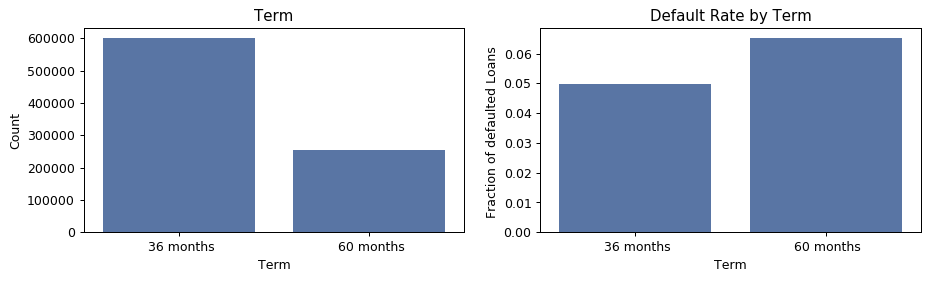

In [42]:
categorical_plot('term','Term')

In [43]:
lend_data['term'] = lend_data['term'].apply(lambda s: np.int8(s.split()[0]))

In [44]:
lend_data['term'].value_counts(normalize=True)

36    0.701218
60    0.298782
Name: term, dtype: float64

In [45]:
lend_data.groupby('term')['default_ind'].value_counts(normalize=True).loc[:,1]

term
36    0.049645
60    0.065177
Name: default_ind, dtype: float64

Inference: About 70% of the completed loans have three-year periods, and the rest have five-year periods. 
Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

# Grade

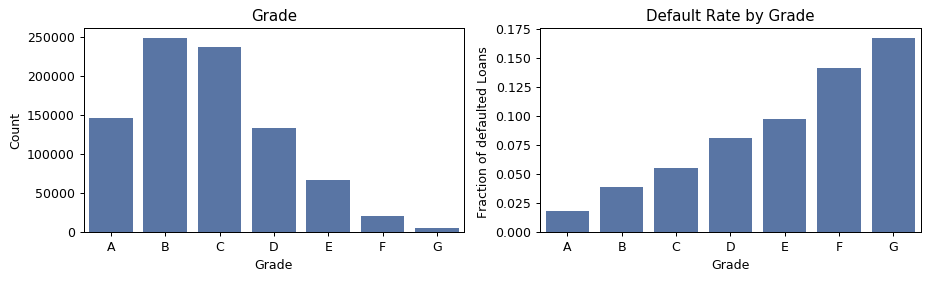

In [46]:
categorical_plot('grade','Grade')

In [47]:
grade_map={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
lend_data['grade']=lend_data['grade'].map(grade_map)

Inference: There's a clear trend of higher percentage of default loans as the grade goes from A to F.

# Employment length

In [48]:
lend_data['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
lend_data['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [49]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [50]:
lend_data['emp_length'] = lend_data['emp_length'].apply(emp_length_to_int)

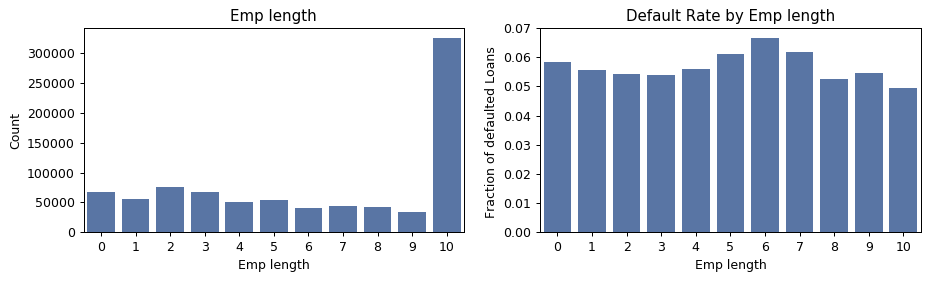

In [51]:
categorical_plot('emp_length','Emp length')

Inference: Loan status does not appear to vary much with employment length on average, except for a small drop 
in default loans for borrowers with over 10 years of employment.

# Home Ownership

In [52]:
lend_data['home_ownership'].value_counts()

MORTGAGE    429106
RENT        342535
OWN          84136
OTHER          144
NONE            45
ANY              3
Name: home_ownership, dtype: int64

In [53]:
lend_data['home_ownership'].replace(['NONE','ANY'],'OTHER',inplace=True)

In [54]:
lend_data['home_ownership'].value_counts()

MORTGAGE    429106
RENT        342535
OWN          84136
OTHER          192
Name: home_ownership, dtype: int64

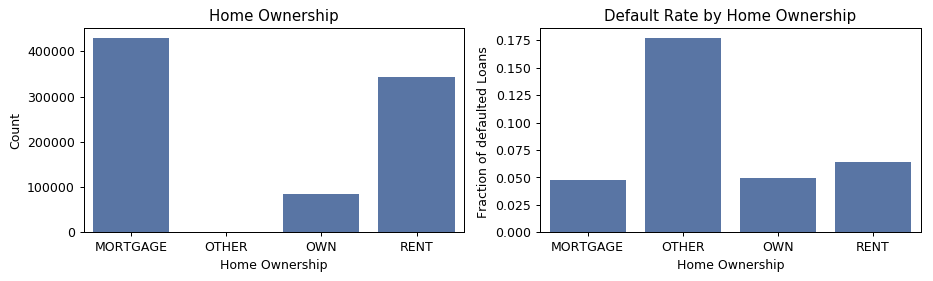

In [55]:
categorical_plot('home_ownership','Home Ownership')

In [56]:
lend_data.groupby('home_ownership')['default_ind'].value_counts(normalize=True).loc[:,1]

home_ownership
MORTGAGE    0.047485
OTHER       0.177083
OWN         0.049147
RENT        0.063999
Name: default_ind, dtype: float64

Inference: There is large differences in default rates by home ownership status. 
Renters and others have a higher probability of default.

# Verification Status

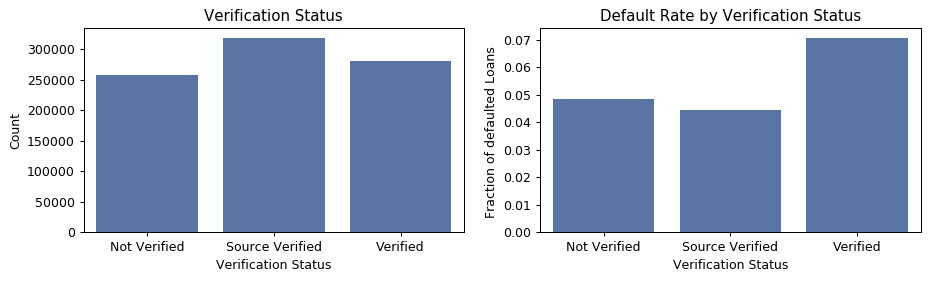

In [57]:
categorical_plot('verification_status','Verification Status')

In [58]:
lend_data.groupby('verification_status')['default_ind'].value_counts(normalize=True).loc[:,1]

verification_status
Not Verified       0.048444
Source Verified    0.044635
Verified           0.070627
Name: default_ind, dtype: float64

Inference: Borrowers with verification status ="verified" seem to default loan more than other 2 status.

# Payment Plan

In [59]:
lend_data['pymnt_plan'].value_counts()

n    855964
y         5
Name: pymnt_plan, dtype: int64

Inference: More than 99% values are "N" , which is equivalent to a constant. Hence can drop this variable.

In [60]:
lend_data=lend_data.drop(['pymnt_plan'],axis=1)

# Purpose

In [61]:
lend_data['purpose'].value_counts()

debt_consolidation    505392
credit_card           200144
home_improvement       49956
other                  40949
major_purchase         16587
small_business          9785
car                     8593
medical                 8193
moving                  5160
vacation                4542
house                   3513
wedding                 2280
renewable_energy         549
educational              326
Name: purpose, dtype: int64

Text(0, 0.5, 'Purpose')

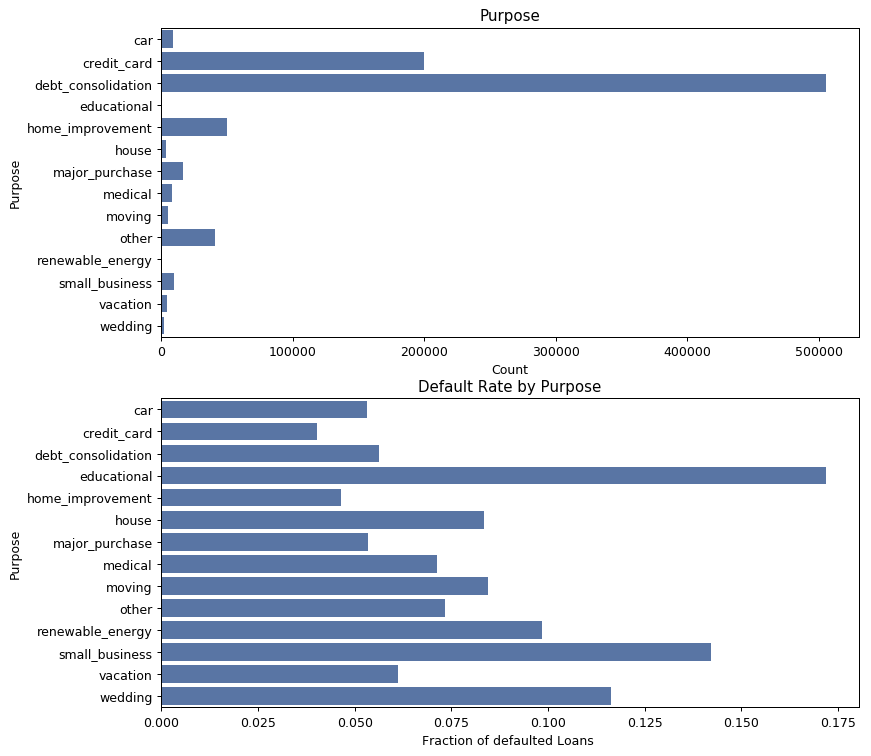

In [62]:

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10), dpi=90)
sns.countplot(y=lend_data['purpose'], order=sorted(lend_data['purpose'].unique()), color='#5975A4',
              saturation=1, ax=ax1)
ax1.set_xlabel('Count')
ax1.set_ylabel('Purpose')
ax1.set_title('Purpose')
charge_off_rates = lend_data.groupby('purpose')['default_ind'].value_counts(normalize=True).loc[:,1]
sns.barplot(y=charge_off_rates.index, x=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
ax2.set_xlabel('Fraction of defaulted Loans ')
ax2.set_title('Default Rate by Purpose')
ax2.set_ylabel('Purpose')

In [63]:
lend_data.groupby('purpose')['default_ind'].value_counts(normalize=True).loc[:,1].sort_values()

purpose
credit_card           0.040266
home_improvement      0.046361
car                   0.053299
major_purchase        0.053536
debt_consolidation    0.056172
vacation              0.061207
medical               0.071280
other                 0.073286
house                 0.083404
moving                0.084496
renewable_energy      0.098361
wedding               0.116228
small_business        0.142054
educational           0.171779
Name: default_ind, dtype: float64

Inference: credit_card has least default rate where as small business and education has higher default rates.

# Address State

Text(0, 0.5, 'Address State')

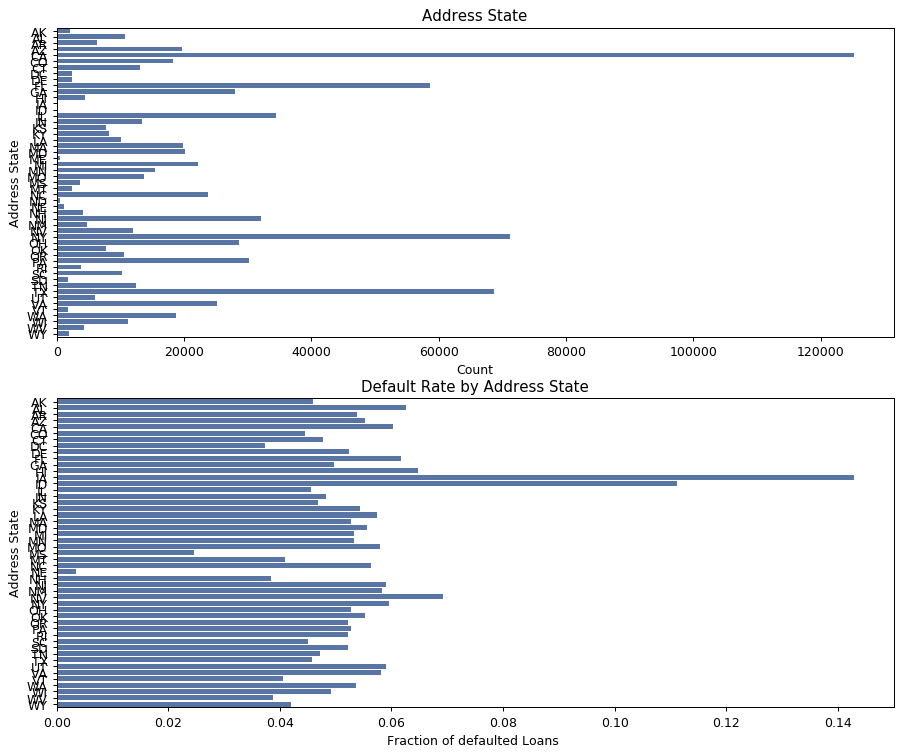

In [64]:

f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,10), dpi=90)
sns.countplot(y=lend_data['addr_state'], order=sorted(lend_data['addr_state'].unique()),  color='#5975A4',
              saturation=1, ax=ax1)
ax1.set_xlabel('Count')
ax1.set_ylabel('Address State')
ax1.set_title('Address State')
charge_off_rates = lend_data.groupby('addr_state')['default_ind'].value_counts(normalize=True).loc[:,1]
sns.barplot(y=charge_off_rates.index, x=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
ax2.set_xlabel('Fraction of defaulted Loans ')
ax2.set_title('Default Rate by Address State')
ax2.set_ylabel('Address State')

In [65]:
lend_data.groupby('addr_state')['default_ind'].value_counts(normalize=True).loc[:,1].sort_values()

addr_state
NE    0.003559
MS    0.024637
DC    0.037364
NH    0.038499
WV    0.038851
VT    0.040502
MT    0.040957
WY    0.042047
CO    0.044424
SC    0.045040
IL    0.045667
TX    0.045788
AK    0.045923
KS    0.046926
TN    0.047208
CT    0.047692
IN    0.048322
WI    0.049112
GA    0.049781
SD    0.052149
RI    0.052225
OR    0.052263
DE    0.052456
MA    0.052735
PA    0.052760
OH    0.052773
MI    0.053303
MN    0.053358
WA    0.053571
AR    0.053915
KY    0.054344
AZ    0.055248
OK    0.055291
MD    0.055569
NC    0.056291
LA    0.057334
MO    0.057993
VA    0.058136
NM    0.058230
NJ    0.058950
UT    0.058960
NY    0.059482
CA    0.060261
FL    0.061717
AL    0.062523
HI    0.064840
NV    0.069328
ID    0.111111
IA    0.142857
Name: default_ind, dtype: float64

The charge-off rate ranges from 2.4% in Mississippi, DC to 14.2% in Iowa.

# Policy Code

In [66]:
lend_data['policy_code'].value_counts()

1.0    855969
Name: policy_code, dtype: int64

Inference: There is only one unique policy code for all the loan applicants. Hence this variable will be dropped.

In [67]:
lend_data=lend_data.drop(['policy_code'],axis=1)

# Application Type

In [68]:
lend_data['application_type'].value_counts(normalize=True)

INDIVIDUAL    0.999484
JOINT         0.000516
Name: application_type, dtype: float64

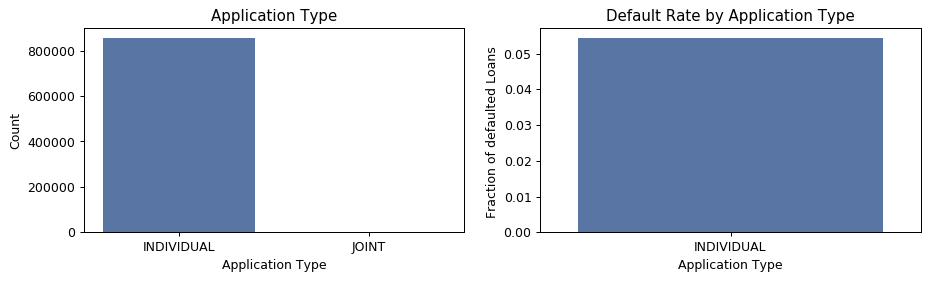

In [69]:
categorical_plot('application_type','Application Type')

Inference: More than 99.94% borrowers have "Individual" application type. Hence drop this variable.

In [70]:
lend_data=lend_data.drop(['application_type'],axis=1)

# Collections 12 months excluding medical collections

In [71]:
lend_data['collections_12_mths_ex_med'].value_counts(normalize=True)

0.0     0.986980
1.0     0.012057
2.0     0.000828
3.0     0.000093
4.0     0.000026
5.0     0.000008
6.0     0.000002
7.0     0.000001
16.0    0.000001
20.0    0.000001
14.0    0.000001
10.0    0.000001
Name: collections_12_mths_ex_med, dtype: float64

In [72]:
lend_data['collections_12_mths_ex_med'].replace([6.0,7.0,16.0,20.0,14.0,10.0],5.0,inplace=True)

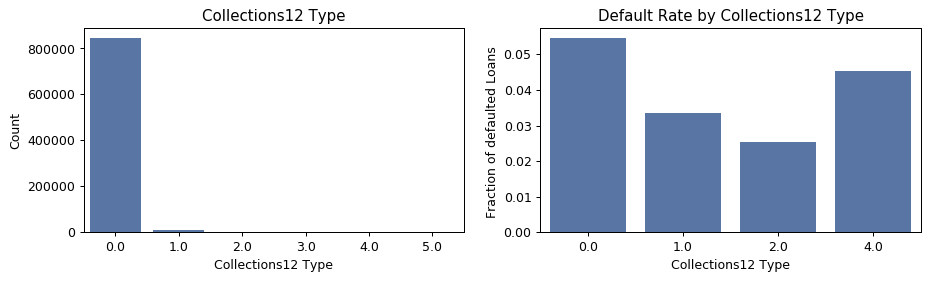

In [73]:
categorical_plot('collections_12_mths_ex_med','Collections12 Type')

In [74]:
lend_data.groupby('collections_12_mths_ex_med')['default_ind'].value_counts(normalize=True).loc[:,1]

collections_12_mths_ex_med
0.0    0.054571
1.0    0.033430
2.0    0.025388
4.0    0.045455
Name: default_ind, dtype: float64

Inference: More than 98% of this variable is 0, hence drop this variable.

In [75]:
lend_data=lend_data.drop(['collections_12_mths_ex_med'],axis=1)

# Delinq_2_Years

In [76]:
lend_data['delinq_2yrs'].value_counts(normalize=True)

0.0     0.809241
1.0     0.127029
2.0     0.037473
3.0     0.013330
4.0     0.005931
5.0     0.003018
6.0     0.001634
7.0     0.000855
8.0     0.000512
9.0     0.000314
10.0    0.000209
11.0    0.000136
12.0    0.000102
13.0    0.000067
14.0    0.000051
15.0    0.000030
16.0    0.000020
18.0    0.000013
17.0    0.000012
19.0    0.000009
22.0    0.000004
26.0    0.000002
30.0    0.000001
21.0    0.000001
20.0    0.000001
39.0    0.000001
27.0    0.000001
29.0    0.000001
24.0    0.000001
Name: delinq_2yrs, dtype: float64

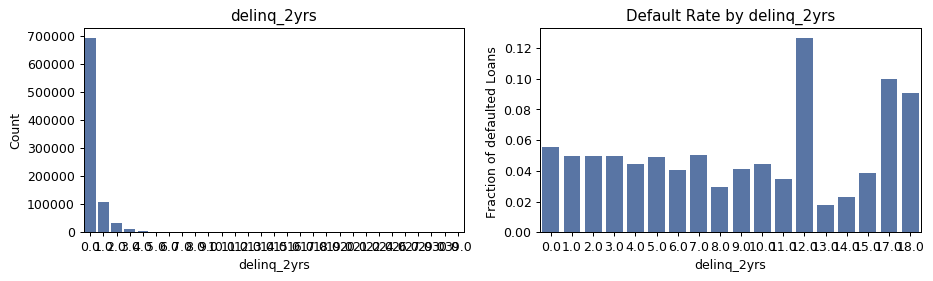

In [77]:
categorical_plot('delinq_2yrs','delinq_2yrs')

In [78]:
lend_data.groupby('delinq_2yrs')['default_ind'].value_counts(normalize=True).loc[:,1].sort_values()

delinq_2yrs
13.0    0.017544
14.0    0.022727
8.0     0.029680
11.0    0.034483
15.0    0.038462
6.0     0.040743
9.0     0.040892
4.0     0.044318
10.0    0.044693
5.0     0.049168
2.0     0.049601
1.0     0.049617
3.0     0.049781
7.0     0.050546
0.0     0.055458
18.0    0.090909
17.0    0.100000
12.0    0.126437
Name: default_ind, dtype: float64

Inference: There is no particular trend to infer anything about this variable.

# Inquiries Last 6 months

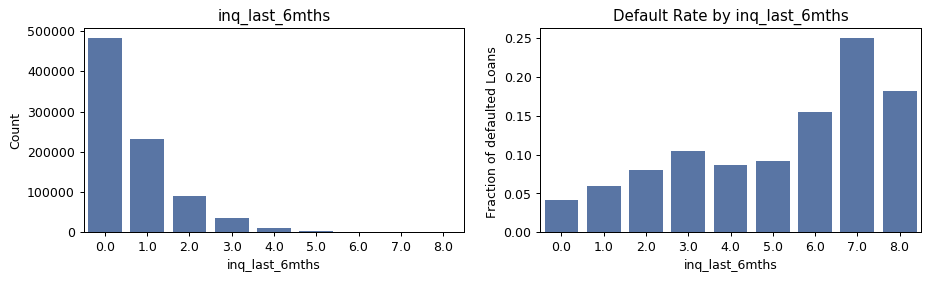

In [79]:
categorical_plot('inq_last_6mths','inq_last_6mths')

In [80]:
lend_data.groupby('inq_last_6mths')['default_ind'].value_counts(normalize=True).loc[:,1].sort_values()

inq_last_6mths
0.0    0.041928
1.0    0.059631
2.0    0.080682
4.0    0.087079
5.0    0.091694
3.0    0.104033
6.0    0.155098
8.0    0.181818
7.0    0.250000
Name: default_ind, dtype: float64

Inference: There is no particular trend to infer anything about this variable.

# Open Credit Lines

Text(0.5, 1.0, 'Number of Open Credit Lines')

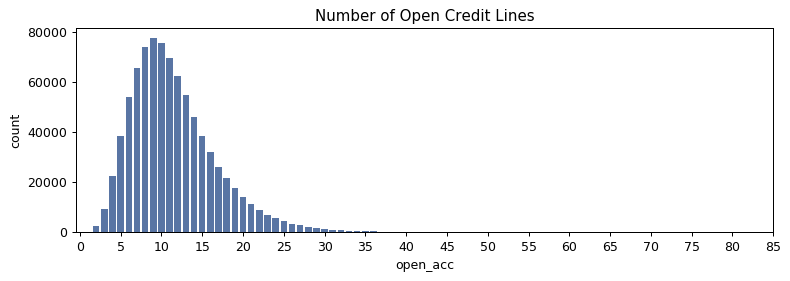

In [81]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(lend_data['open_acc'], order=sorted(lend_data['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

In [82]:
lend_data.groupby('default_ind')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,11.570042,5.327422,0.0,8.0,11.0,14.0,90.0
1,46467.0,11.061721,4.934646,0.0,8.0,10.0,14.0,76.0


Inference:There is no difference in number of credit lines between paid loans and defaulted loans.

# Public Records

In [83]:
lend_data['pub_rec'].value_counts().sort_index()

0.0     725455
1.0     108920
2.0      14250
3.0       4305
4.0       1496
5.0        728
6.0        366
7.0        167
8.0        110
9.0         46
10.0        41
11.0        21
12.0        14
13.0        12
14.0         2
15.0         6
16.0         5
17.0         3
18.0         5
19.0         2
21.0         4
22.0         1
23.0         1
26.0         1
28.0         1
34.0         1
40.0         1
49.0         2
54.0         1
63.0         1
86.0         1
Name: pub_rec, dtype: int64

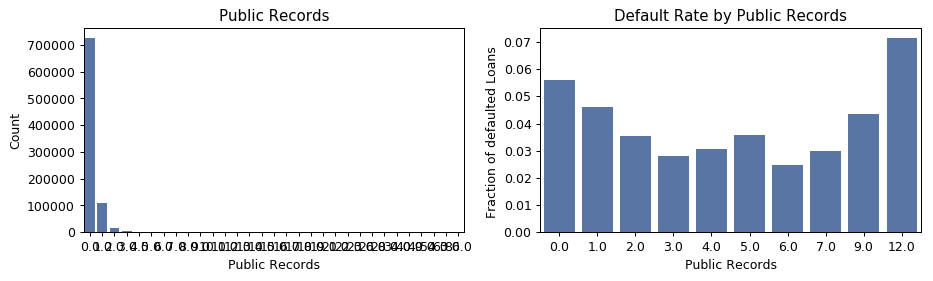

In [84]:
categorical_plot('pub_rec','Public Records')

In [85]:
lend_data.groupby('pub_rec')['default_ind'].value_counts(normalize=True).loc[:,1].sort_values()

pub_rec
6.0     0.024590
3.0     0.028107
7.0     0.029940
4.0     0.030749
2.0     0.035509
5.0     0.035714
9.0     0.043478
1.0     0.046089
0.0     0.056145
12.0    0.071429
Name: default_ind, dtype: float64

Inference:  There is no particular trend to infer anything about this variable. 

# Total Credit Lines

In [86]:
lend_data['total_acc'].nunique()


134

Text(0.5, 1.0, 'Number of total Credit Lines')

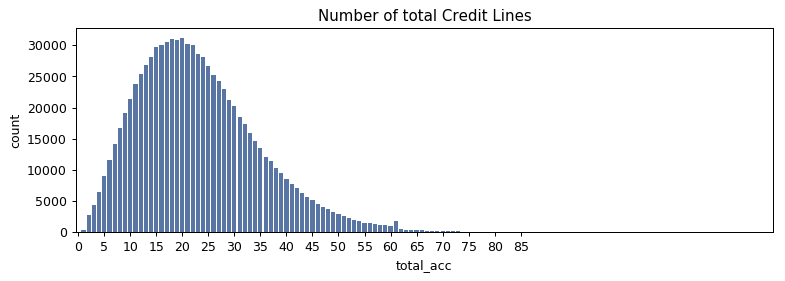

In [87]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(lend_data['total_acc'], order=sorted(lend_data['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of total Credit Lines')

In [88]:
lend_data.groupby('default_ind')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
default_ind,,,,,,,,
0,809502.0,25.328980,11.832300,2.0,17.0,24.0,32.0,169.0
1,46467.0,24.229044,11.532493,2.0,16.0,23.0,31.0,110.0


Inference: There is no difference in total number of credit lines between paid loans and defaulted loans.

# Account now delinq

In [89]:
lend_data['acc_now_delinq'].value_counts(normalize=True)

0.0     0.995409
1.0     0.004314
2.0     0.000231
3.0     0.000033
4.0     0.000007
5.0     0.000004
6.0     0.000001
14.0    0.000001
Name: acc_now_delinq, dtype: float64

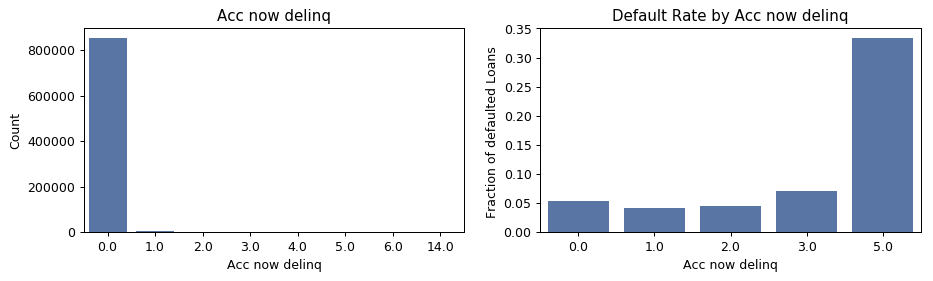

In [90]:
categorical_plot('acc_now_delinq','Acc now delinq')

In [91]:
lend_data.groupby('acc_now_delinq')['default_ind'].value_counts(normalize=True).loc[:,1]

acc_now_delinq
0.0    0.054341
1.0    0.041701
2.0    0.045455
3.0    0.071429
5.0    0.333333
Name: default_ind, dtype: float64

Inference: More than 99% of this variable is 0, hence drop this variable.

In [92]:
lend_data=lend_data.drop(['acc_now_delinq'],axis=1)

# Earliest credit line

In [93]:
lend_data['earliest_cr_line'] = lend_data['earliest_cr_line'].apply(lambda s: int(s[-4:]))

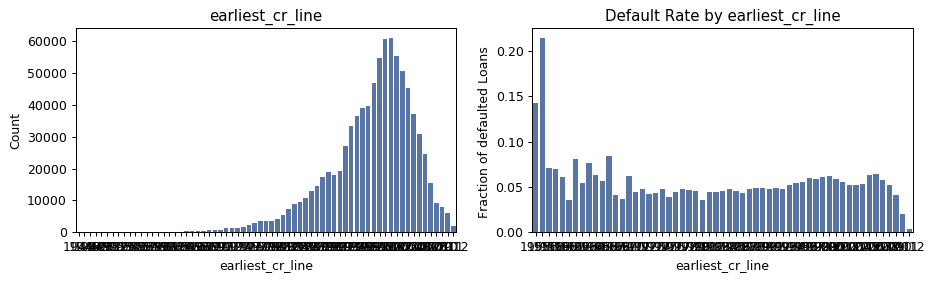

In [94]:
categorical_plot('earliest_cr_line','earliest_cr_line')

Inference: From above graph we observe default rate is not dependendent on earliest credit line, hence drop the variable.

In [95]:
lend_data=lend_data.drop(['earliest_cr_line'],axis=1)

In [96]:
lend_data.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'tot_cur_bal', 'total_rev_hi_lim', 'default_ind'],
      dtype='object')

In [97]:
lend_data.shape

(855969, 22)

# Chi-Squared Test for catagorical features

In [98]:
# Define the class so it is convenient to use

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfTabular = None
        self.dfExpected = None
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX, alpha)
    
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} could be an IMPORTANT Predictor".format(colX)
        else:
            result="{0} MAY NOT be an important predictor.".format(colX)

        print(result)

In [99]:
# Instantiate the class
ChTest = ChiSquare(lend_data)

# Pass all the columns for Chi-Squared test with response variable 'TripType' to find if they are important predictors
testColumns = ['term','grade','emp_length','home_ownership','verification_status','purpose','addr_state']
for var in testColumns:
    ChTest.TestIndependence(colX=var,colY="default_ind" ) 

term could be an IMPORTANT Predictor
grade could be an IMPORTANT Predictor
emp_length could be an IMPORTANT Predictor
home_ownership could be an IMPORTANT Predictor
verification_status could be an IMPORTANT Predictor
purpose could be an IMPORTANT Predictor
addr_state could be an IMPORTANT Predictor


Above Chi-Squared test analysis shows that all the categorical variables could be important predictors

# Dummifying Nominal Columns

In [100]:
catCols=['home_ownership','verification_status','purpose','addr_state']
dummy_cols = pd.get_dummies(lend_data[catCols], drop_first = True)
lend_data=lend_data.drop(catCols,axis=1)
data_clean= pd.concat([lend_data,dummy_cols], axis =1)

In [101]:
data_clean.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'annual_inc',
       'issue_d', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal',
       'total_rev_hi_lim', 'default_ind', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA',
       'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_I

# Train test split based on issue date

In [102]:
data_clean=data_clean.drop(['issue_d'],axis=1)
data_clean['default_ind']=lend_data['default_ind']
lendBackup=data_clean
y=data_clean['default_ind']
data_clean=data_clean.drop(['default_ind'],axis=1)
X=data_clean
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Model Evaluation and Validation

# Logistic Regression 

In [104]:
final_model=LogisticRegression(solver='liblinear')
final_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
pred=final_model.predict(X_test)
Predictproba = final_model.predict_proba(X_test)[:,1] 
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

0.9450214376672079
[[161780     11]
 [  9401      2]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    161791
           1       0.15      0.00      0.00      9403

    accuracy                           0.95    171194
   macro avg       0.55      0.50      0.49    171194
weighted avg       0.90      0.95      0.92    171194



Due to class imbalance all the defaulters are predicted as non defaulters.

# Applying SMOTE to handle imbalanced class problem

In [106]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [107]:
np.bincount(y_train)

array([647711, 647711], dtype=int64)

In [108]:
final_model=LogisticRegression(solver='liblinear')
final_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
pred=final_model.predict(X_test)
Predictproba = final_model.predict_proba(X_test)[:,1] 
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(f1_score(y_test,pred))

0.6290641027138801
[[101363  60428]
 [  3074   6329]]
              precision    recall  f1-score   support

           0       0.97      0.63      0.76    161791
           1       0.09      0.67      0.17      9403

    accuracy                           0.63    171194
   macro avg       0.53      0.65      0.46    171194
weighted avg       0.92      0.63      0.73    171194

0.16620273109243697


# ROC Curve

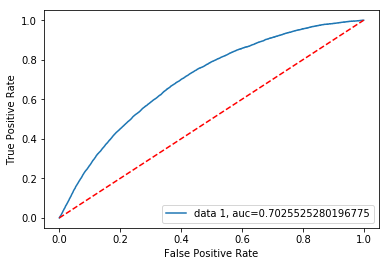

In [110]:
fpr, tpr, _ = metrics.roc_curve(y_test,  Predictproba)
auc = metrics.roc_auc_score(y_test, Predictproba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [111]:
threshold = 0.45
predicted_proba = final_model.predict_proba(X_test)
predth = (predicted_proba [:,1] >= threshold).astype('int')
print(accuracy_score(y_test,predth))
print(confusion_matrix(y_test,predth))
print(classification_report(y_test,predth))
print(f1_score(y_test,predth))

0.5428811757421405
[[85763 76028]
 [ 2228  7175]]
              precision    recall  f1-score   support

           0       0.97      0.53      0.69    161791
           1       0.09      0.76      0.15      9403

    accuracy                           0.54    171194
   macro avg       0.53      0.65      0.42    171194
weighted avg       0.93      0.54      0.66    171194

0.15495756214500142


# Feature Engineering

Address State doesnt seem to affect metrics much. Hence drop this feature.

In [112]:
lendBackup=lendBackup.drop(['addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA',
       'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL',
       'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA',
       'addr_state_MA', 'addr_state_MD', 'addr_state_ME', 'addr_state_MI',
       'addr_state_MN', 'addr_state_MO', 'addr_state_MS', 'addr_state_MT',
       'addr_state_NC', 'addr_state_ND', 'addr_state_NE', 'addr_state_NH',
       'addr_state_NJ', 'addr_state_NM', 'addr_state_NV', 'addr_state_NY',
       'addr_state_OH', 'addr_state_OK', 'addr_state_OR', 'addr_state_PA',
       'addr_state_RI', 'addr_state_SC', 'addr_state_SD', 'addr_state_TN',
       'addr_state_TX', 'addr_state_UT', 'addr_state_VA', 'addr_state_VT',
       'addr_state_WA', 'addr_state_WI', 'addr_state_WV', 'addr_state_WY'],axis=1)


In [113]:
lendBackup.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal',
       'total_rev_hi_lim', 'default_ind', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

# Checking for multicollinearity

Features having more than 0.40 correlation

In [114]:
cor = lendBackup.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.50) | (cor < -0.50)]

grade                         int_rate                               0.954900
total_acc                     open_acc                               0.694850
total_rev_hi_lim              revol_bal                              0.806634
verification_status_Verified  verification_status_Source Verified   -0.536370
purpose_debt_consolidation    purpose_credit_card                   -0.663284
dtype: float64

# Variance Inflation Factor

In [115]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
for i in range(len(lendBackup.columns[:])):
    v=vif(np.matrix(lendBackup[:]),i)
    print("Variance inflation factor for {}: {}".format(lendBackup.columns[i],round(v,2)))

C:\Users\rashm\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Variance inflation factor for loan_amnt: 6.71
Variance inflation factor for term: 23.41
Variance inflation factor for int_rate: 115.33
Variance inflation factor for grade: 61.02
Variance inflation factor for emp_length: 4.06
Variance inflation factor for annual_inc: 3.16
Variance inflation factor for dti: 2.2
Variance inflation factor for delinq_2yrs: 1.17
Variance inflation factor for inq_last_6mths: 1.72
Variance inflation factor for open_acc: 12.02
Variance inflation factor for pub_rec: 1.16
Variance inflation factor for revol_bal: 6.41
Variance inflation factor for revol_util: 9.87
Variance inflation factor for total_acc: 11.82
Variance inflation factor for tot_cur_bal: 3.35
Variance inflation factor for total_rev_hi_lim: 6.89
Variance inflation factor for default_ind: 1.1
Variance inflation factor for home_ownership_OTHER: 1.0
Variance inflation factor for home_ownership_OWN: 1.26
Variance inflation factor for home_ownership_RENT: 2.48
Variance inflation factor for verification_st

In [116]:
lendBackup=lendBackup.drop(['purpose_debt_consolidation','term','verification_status_Verified','home_ownership_RENT',
'verification_status_Source Verified','purpose_credit_card','home_ownership_OWN','purpose_small_business',
'purpose_other','purpose_home_improvement','purpose_major_purchase','purpose_medical','purpose_house','purpose_moving','purpose_wedding',
'purpose_vacation','purpose_renewable_energy','purpose_educational','home_ownership_OTHER'],axis=1)

In [117]:
lendBackup.columns

Index(['loan_amnt', 'int_rate', 'grade', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'tot_cur_bal', 'total_rev_hi_lim',
       'default_ind'],
      dtype='object')

# Feature Importance using Random Forest

In [120]:

backup1=lendBackup
y=lendBackup['default_ind']
lendBackup=lendBackup.drop(['default_ind'],axis=1)
X=lendBackup

In [121]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [122]:
rfmodel=RandomForestClassifier(n_estimators=10,max_depth=20)
rffit=rfmodel.fit(X_train,y_train)
features=lendBackup.columns
importances = rffit.feature_importances_
df1=pd.DataFrame(data=features,columns=['feature'])
df2=pd.DataFrame(data=importances,columns=['Importance'])
impDF=pd.concat([df1,df2],axis=1)
impDF.sort_values(by='Importance',ascending=False)

,feature,Importance
1,int_rate,0.116933
10,revol_bal,0.098241
5,dti,0.097754
11,revol_util,0.094305
13,tot_cur_bal,0.089356
4,annual_inc,0.087011
14,total_rev_hi_lim,0.084379
0,loan_amnt,0.078983
12,total_acc,0.071372
8,open_acc,0.059106


In [123]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

# Final Logistic Regression

In [124]:
final_model=LogisticRegression(solver='liblinear')
final_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [125]:
pred=final_model.predict(X_test)
Predictproba = final_model.predict_proba(X_test)[:,1] 
print(accuracy_score(y_test,pred))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(f1_score(y_test,pred))

0.6091919109314579
[[97807 63984]
 [ 2920  6483]]
              precision    recall  f1-score   support

           0       0.97      0.60      0.75    161791
           1       0.09      0.69      0.16      9403

    accuracy                           0.61    171194
   macro avg       0.53      0.65      0.45    171194
weighted avg       0.92      0.61      0.71    171194

0.1623388005508952


# KS Statistic plot

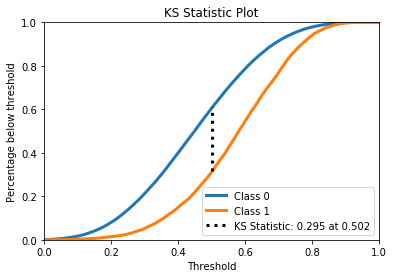

In [126]:
y_probas = final_model.predict_proba(X_test)
skplt.metrics.plot_ks_statistic(y_test, y_probas)

# Cumulative Gains Curve

C:\Users\rashm\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


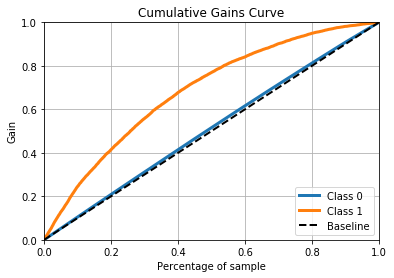

In [127]:
skplt.metrics.plot_cumulative_gain(y_test, y_probas)

# Lift Curve

C:\Users\rashm\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


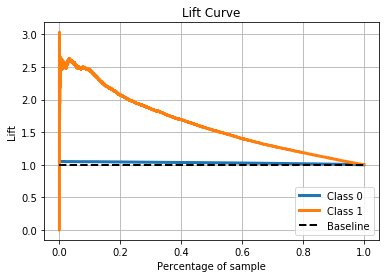

In [128]:
skplt.metrics.plot_lift_curve(y_test, y_probas)

# Grid Search CV with Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid={
           'max_depth':[3,5],
            'criterion':['gini','entropy'],
            'min_samples_split':[5,7],
            'n_estimators':[5,10]
           }

rffit=GridSearchCV(RandomForestClassifier(),param_grid=param_grid,cv=5,scoring='f1',n_jobs=-1)
rffit.fit(X_train,y_train)


In [ ]:
rffit.best_estimator_

In [129]:
rfmodel=RandomForestClassifier(criterion='gini',max_depth=5,min_samples_leaf=1, min_samples_split=7,
                      n_estimators=10)
rffit=rfmodel.fit(X_train,y_train)

In [130]:
predrf=rffit.predict(X_test)
print(accuracy_score(y_test,predrf))
print(confusion_matrix(y_test,predrf))
print(classification_report(y_test,predrf))


0.7971833124992699
[[132706  29085]
 [  5636   3767]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.88    161791
           1       0.11      0.40      0.18      9403

    accuracy                           0.80    171194
   macro avg       0.54      0.61      0.53    171194
weighted avg       0.91      0.80      0.85    171194



# Gradient Boosting

In [133]:
grid=GradientBoostingClassifier(max_depth=5,n_estimators=2)
grid.fit(X_train,y_train)
predgb=grid.predict(X_test)
print(accuracy_score(y_test,predgb))
print(confusion_matrix(y_test,predgb))
print(classification_report(y_test,predgb))

0.8410283070668364
[[141375  20416]
 [  6799   2604]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91    161791
           1       0.11      0.28      0.16      9403

    accuracy                           0.84    171194
   macro avg       0.53      0.58      0.54    171194
weighted avg       0.91      0.84      0.87    171194

